In [1]:
import sys
sys.path.append('../')
sys.path.append('/Users/sdbykov/work/my_packages/nway')

In [2]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import fits_to_pandas, pandas_to_fits
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import astropy.io.fits as fits
import healpy as hp
import nway_python_api as nway
%matplotlib inline

This is NWAY Python API
nwaylib file /Users/sdbykov/work/my_packages/nway/nwaylib/__init__.py


In [3]:
def match_cats(magnitude_columns=[]):

    ero_table = nway.table_from_fits(data_path+'ERO_lhpv_03_23_sd01_a15_g14.fits', )
    ero_random_table = nway.table_from_fits(data_path+'ERO_lhpv_03_23_sd01_a15_g14_shifted.fits',)

    desi_table = nway.table_from_fits(data_path+'desi_lh.fits', poserr_value=0.1, magnitude_columns=magnitude_columns)

    ero_pandas = fits_to_pandas('ERO_lhpv_03_23_sd01_a15_g14.fits')
    desi_pandas = fits_to_pandas('desi_lh.fits')




    nway_res_ero_orig = nway.nwaylib.nway_match(
    [ero_table, desi_table],
    match_radius = 20,
    prior_completeness = 1,
    mag_include_radius = 3.0,
    store_mag_hists = True

    )

    nway_res_ero_random_orig = nway.nwaylib.nway_match(
    [ero_random_table, desi_table],
    match_radius = 20,
    prior_completeness = 1,
    mag_include_radius = 3.0,
    store_mag_hists = True
    )


    nway_res_ero = nway_res_ero_orig
    nway_res_ero_random = nway_res_ero_random_orig

    nway_res_ero.sort_values(by=['EROSITA', 'prob_this_match' ], inplace=True, ascending=[True, False])
    nway_res_ero_random.sort_values(by=['EROSITA', 'prob_this_match' ], inplace=True, ascending=[True, False])

    cutoffs, nway_efficiency, nway_purity = nway.calibrate_cutoff(nway_res_ero, nway_res_ero_random)


    true_ctps = pd.read_pickle(data_path+'final_ctps_ero_csc_desi.pkl')


    nway_res_ero  = nway_res_ero.merge(ero_pandas, on='EROSITA')
    nway_res_ero  = nway_res_ero.merge(desi_pandas, on='DESI', suffixes=('_ero', '_desi'))

    nway_res_ero['true_ctps'] = False

    for desi_id, ero_id in zip(true_ctps['desi_id'], true_ctps['ID_ero']):
        id_tmp  = (nway_res_ero.desi_id == desi_id) & (nway_res_ero.ID==ero_id)
        #print(np.sum(id_tmp))
        nway_res_ero.loc[id_tmp, 'true_ctps'] = True


    completeness_validation = []
    purity_validation = []

    num_ctps = np.sum(nway_res_ero.true_ctps)
    cutoffs = np.linspace(0.01, 0.99, 100)
    for cutoff in tqdm(cutoffs):
        tp = len(nway_res_ero.query("true_ctps==True & match_flag==1 & prob_this_match>@cutoff"))
        fp = len(nway_res_ero.query("true_ctps==False & match_flag==1 & prob_this_match>@cutoff"))
        fn = len(nway_res_ero.query("true_ctps==True & match_flag==0 & prob_this_match>@cutoff"))
        tn = len(nway_res_ero.query("true_ctps==False & match_flag==0 & prob_this_match>@cutoff"))

        #completeness = tp/(tp+fp)
        completeness = tp / num_ctps
        completeness_validation.append(completeness)
        purity = tp/(tp+fn)
        purity_validation.append(purity)

    completeness_validation = np.array(completeness_validation)
    purity_validation = np.array(purity_validation)


    fig,  ax =  plt.subplots( figsize = (12,12))
    ax.plot(cutoffs, purity_validation, label = 'validation purity = [true positives]/[true positives + false negatives]')
    ax.plot(cutoffs, completeness_validation, label = 'validation completeness = [true positives]/[num of validation ctps]')


    sns.ecdfplot(nway_res_ero.prob_has_match, label = 'nway cumsum p_any', complementary=True, ax=ax)

    plt.ylim(0.5, 1.1)
    plt.xlabel('p_any cutoff')
    plt.ylabel('metric')
    plt.legend()
    
    return nway_res_ero, cutoffs, purity_validation, completeness_validation

    adding angular separation columns
matching:  78684 matches after filtering by search radius
Primary catalogue "EROSITA" (9500), density gives 2.13e+07 objects on entire sky
Catalogue "DESI" (2418574), density gives 2.39e+09 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
100%|██████████| 9500/9500 [00:02<00:00, 3239.18it/s]
Incorporating bias "DESI:nnprior" ...
magnitude histogramming: using user-supplied histogram for "DESI_nnprior"


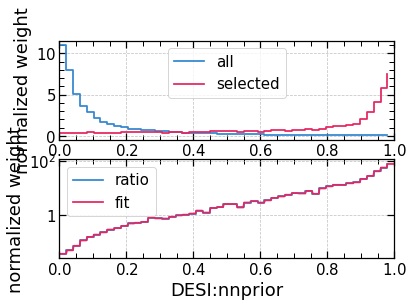


Computing final probabilities ...
    grouping by primary catalogue ID and flagging ...
    adding angular separation columns
matching:  54727 matches after filtering by search radius
Primary catalogue "EROSITA" (8175), density gives 1.83e+07 objects on entire sky
Catalogue "DESI" (2418574), density gives 2.39e+09 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
100%|██████████| 8175/8175 [00:02<00:00, 3309.57it/s]
Incorporating bias "DESI:nnprior" ...
magnitude histogramming: using user-supplied histogram for "DESI_nnprior"


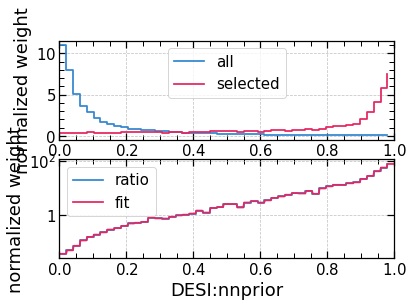


Computing final probabilities ...
    grouping by primary catalogue ID and flagging ...



For a false detection rate of <1%
--> use only counterparts with p_any>0.92 (43.54% of matches)

For a false detection rate of <3%
--> use only counterparts with p_any>0.81 (60.65% of matches)

For a false detection rate of <5%
--> use only counterparts with p_any>0.74 (67.07% of matches)

For a false detection rate of <10%
--> use only counterparts with p_any>0.60 (76.45% of matches)
The efficiency is 83.18%
The purity is  83.47%


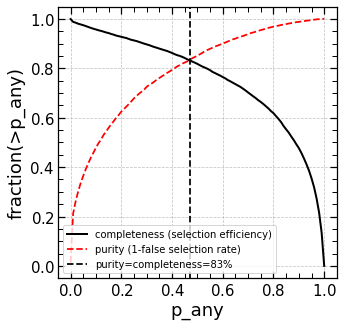

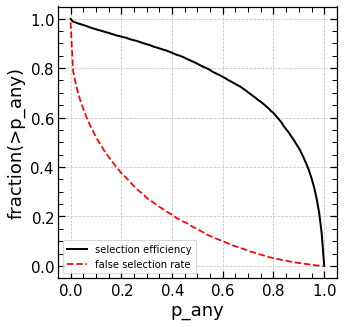

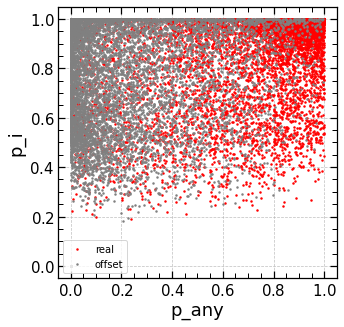

100%|██████████| 100/100 [00:01<00:00, 75.88it/s]


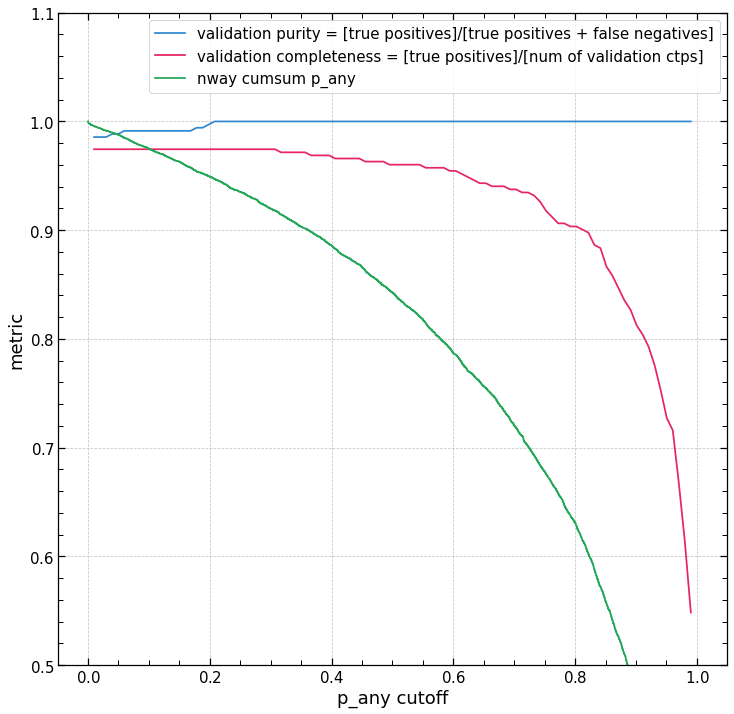

In [4]:

magnitude_columns = [('nnprior', '../1_csc-desi-photo-prior/model/nn-prior.csv'),]

nway_res_ero, cutoffs, purity_validation, completeness_validation = match_cats(magnitude_columns)


In [5]:
inspect_cols = ['EROSITA', 'Separation_EROSITA_DESI','match_flag', 'prob_has_match', 'prob_this_match', 'dist_post', 'dist_bayesfactor', 'nnprior', 'ID', 'pos_err', 'desi_id', 'true_ctps']
df_inspect = nway_res_ero.query('true_ctps==1 & match_flag==0')[inspect_cols]
ids = df_inspect.ID
df_inspect

,EROSITA,Separation_EROSITA_DESI,match_flag,prob_has_match,prob_this_match,dist_post,dist_bayesfactor,nnprior,ID,pos_err,desi_id,true_ctps
41763,5561,3.455432,0,0.833771,0.055058,0.545847,9.458450,0.122654,b'SRGe J105151.7+573908',4.772239,b'9011_610725_1881',True
45666,6106,5.271706,0,0.413841,0.199395,0.425291,9.247819,0.115532,b'SRGe J104629.5+591844',5.520634,b'9011_615260_643',True
56647,7686,1.690694,0,0.978016,0.173830,0.556258,9.476726,0.731452,b'SRGe J104644.2+590029',5.187625,b'9011_614517_183',True
57533,7809,3.226917,0,0.507619,0.033709,0.481281,9.346047,0.007274,b'SRGe J103206.5+574821',5.718590,b'9011_610714_3788',True
65280,8919,3.813600,0,0.137918,0.195691,0.383693,9.172768,0.023168,b'SRGe J104413.6+590817',7.022647,b'9011_615259_241',True


In [9]:
#query nway_res_ero for all ids in df_inspect
nway_res_ero_bad_assign = nway_res_ero.query('ID in @ids')

In [10]:

nway_res_ero_bad_assign[nway_res_ero_bad_assign.EROSITA==7686][inspect_cols]


,EROSITA,Separation_EROSITA_DESI,match_flag,prob_has_match,prob_this_match,dist_post,dist_bayesfactor,nnprior,ID,pos_err,desi_id,true_ctps
56644,7686,2.632557,1,0.978016,0.381239,0.537520,9.443882,0.872424,b'SRGe J104644.2+590029',5.187625,b'9011_614517_187',False
56645,7686,5.850851,2,0.978016,0.249334,0.411757,9.223664,0.887548,b'SRGe J104644.2+590029',5.187625,b'9011_614517_164',False
56646,7686,8.798351,2,0.978016,0.192115,0.238914,8.875388,0.936085,b'SRGe J104644.2+590029',5.187625,b'9011_614517_205',False
56647,7686,1.690694,0,0.978016,0.173830,0.556258,9.476726,0.731452,b'SRGe J104644.2+590029',5.187625,b'9011_614517_183',True
56648,7686,16.531542,0,0.978016,0.002379,0.008190,7.295421,0.838064,b'SRGe J104644.2+590029',5.187625,b'9011_614517_211',False
56649,7686,17.592333,0,0.978016,0.000570,0.004198,7.003448,0.758659,b'SRGe J104644.2+590029',5.187625,b'9011_614517_181',False
56650,7686,19.400916,0,0.978016,0.000351,0.001215,6.463792,0.831867,b'SRGe J104644.2+590029',5.187625,b'9011_614517_117',False
56651,7686,14.012277,0,0.978016,0.000090,0.033326,7.916081,0.073999,b'SRGe J104644.2+590029',5.187625,b'9011_614517_177',False
56652,7686,16.315072,0,0.978016,0.000062,0.009335,7.352773,0.156218,b'SRGe J104644.2+590029',5.187625,b'9011_614517_202',False
56653,7686,15.178807,0,0.978016,0.000015,0.017987,7.641416,0.010918,b'SRGe J104644.2+590029',5.187625,b'9011_614517_170',False


In [11]:

nway_res_ero_bad_assign[nway_res_ero_bad_assign.EROSITA==5561][inspect_cols]

,EROSITA,Separation_EROSITA_DESI,match_flag,prob_has_match,prob_this_match,dist_post,dist_bayesfactor,nnprior,ID,pos_err,desi_id,true_ctps
41761,5561,10.055115,1,0.833771,0.715989,0.145191,8.608653,0.907294,b'SRGe J105151.7+573908',4.772239,b'9011_610725_1817',False
41762,5561,8.306671,0,0.833771,0.129252,0.255728,8.914628,0.547246,b'SRGe J105151.7+573908',4.772239,b'9011_610725_1832',False
41763,5561,3.455432,0,0.833771,0.055058,0.545847,9.458450,0.122654,b'SRGe J105151.7+573908',4.772239,b'9011_610725_1881',True
41764,5561,7.834043,0,0.833771,0.041990,0.288869,8.987332,0.233805,b'SRGe J105151.7+573908',4.772239,b'9011_610725_1898',False
41765,5561,14.525028,0,0.833771,0.038937,0.015010,7.561518,0.842114,b'SRGe J105151.7+573908',4.772239,b'9011_610725_1787',False
41766,5561,12.221954,0,0.833771,0.009436,0.055613,8.148604,0.273849,b'SRGe J105151.7+573908',4.772239,b'9011_610725_1919',False
41767,5561,14.135874,0,0.833771,0.007033,0.019093,7.667817,0.468015,b'SRGe J105151.7+573908',4.772239,b'9011_610725_1821',False
41768,5561,15.208009,0,0.833771,0.000947,0.009665,7.367979,0.211704,b'SRGe J105151.7+573908',4.772239,b'9011_610725_1858',False
41769,5561,17.315751,0,0.833771,0.000816,0.002163,6.714642,0.535800,b'SRGe J105151.7+573908',4.772239,b'9011_610725_1853',False
41770,5561,15.683767,0,0.833771,0.000324,0.007019,7.227908,0.126443,b'SRGe J105151.7+573908',4.772239,b'9011_610725_1836',False
